In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import StaleElementReferenceException
import adblockparser
import time
import threading

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with open("easylist.txt", "r", encoding="utf-8") as file:
    raw_rules = file.readlines()
rules = adblockparser.AdblockRules(raw_rules)

In [3]:
def check_if_ad(url):
    return rules.should_block(url)


In [4]:
df_domains = pd.read_csv('domainsToInspect.csv')
domains = df_domains.iloc[:, 0].tolist()

In [5]:
options = webdriver.ChromeOptions()
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.6167.184 Safari/537.36")

In [6]:
def count_ads(domain):
    global driver  # Use the global driver instance
    try:
        driver.get(domain)
        time.sleep(5)  # Wait for the page to load
        ads_count = 0
        unique_ad_servers = set()
        WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.TAG_NAME, "script")))
        time.sleep(5)  
        elements = driver.find_elements(By.TAG_NAME, "iframe") + driver.find_elements(By.TAG_NAME, "img") + driver.find_elements(By.TAG_NAME, "script")
        for element in elements:
            src = element.get_attribute('src')
            if src and check_if_ad(src):
                ads_count += 1
                unique_ad_servers.add(src)
        driver.quit()
        results.append((domain, len(unique_ad_servers), ads_count))
        print(f"{counter} Domain: {domain}, Unique Ad Servers: {len(unique_ad_servers)}, Ads Count: {ads_count}")
    except StaleElementReferenceException:
        try:
            driver.quit()  # Quit the driver in case of an exception
            time.sleep(2)  # Wait for the driver to quit
            initialize_driver()
            driver.get(domain)
            time.sleep(5)  # Wait for the page to load
            ads_count = 0
            unique_ad_servers = set()
            WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.TAG_NAME, "script")))
            time.sleep(5)
            elements = driver.find_elements(By.TAG_NAME, "iframe") + driver.find_elements(By.TAG_NAME, "img") + driver.find_elements(By.TAG_NAME, "script")
            for element in elements:
                src = element.get_attribute('src')
                if src and check_if_ad(src):
                    ads_count += 1
                    unique_ad_servers.add(src)
            driver.quit()
        except StaleElementReferenceException:
            print(f"StaleElementReferenceException for {domain}")
            driver.quit()
    except Exception as e:
        print(f"Exception for {domain}: {e}")
        driver.quit()


In [7]:
# Function to handle threading and timeout
def thread_count_ads(domain):
    thread = threading.Thread(target=count_ads, args=(f'https://{domain}',))
    thread.start()
    thread.join(timeout=600)  # 7 minutes timeout
    if thread.is_alive():
        print(f"Timeout reached for domain {domain}, moving to next.")
        driver.quit()
        initialize_driver()

In [8]:
def initialize_driver():
    global driver
    time.sleep(2)
    driver = webdriver.Chrome(options=options)

In [9]:
results = []
counter = 0

In [10]:
initialize_driver()

In [11]:
for domain in domains:
    time.sleep(2)
    initialize_driver()
    counter += 1
    thread_count_ads(domain)

1 Domain: https://msn.com, Unique Ad Servers: 8, Ads Count: 12
2 Domain: https://cnn.com, Unique Ad Servers: 31, Ads Count: 31
3 Domain: https://dailymail.co.uk, Unique Ad Servers: 23, Ads Count: 25
4 Domain: https://foxnews.com, Unique Ad Servers: 15, Ads Count: 15
5 Domain: https://newsweek.com, Unique Ad Servers: 14, Ads Count: 14
6 Domain: https://worldometers.info, Unique Ad Servers: 12, Ads Count: 13
7 Domain: https://nytimes.com, Unique Ad Servers: 8, Ads Count: 8
9 Domain: https://express.co.uk, Unique Ad Servers: 11, Ads Count: 11
10 Domain: https://indiatimes.com, Unique Ad Servers: 40, Ads Count: 40
11 Domain: https://infobae.com, Unique Ad Servers: 20, Ads Count: 20
12 Domain: https://elpais.com, Unique Ad Servers: 2, Ads Count: 2
13 Domain: https://usatoday.com, Unique Ad Servers: 16, Ads Count: 18
14 Domain: https://spiegel.de, Unique Ad Servers: 0, Ads Count: 0
15 Domain: https://forbes.com, Unique Ad Servers: 24, Ads Count: 26
16 Domain: https://cnet.com, Unique Ad Serv

In [12]:
df_results = pd.DataFrame(results, columns=['Domain', 'UniqueAdServers', 'AdsCount'])
df_results.to_csv('Final_try.csv', index=False)
driver.quit() 

In [13]:
url_pattern = r'(https?://)?(www\.)?([A-Za-z0-9.-]+)'
df_results['domain'] = df_results.iloc[:,0].str.extract(url_pattern)[2]

In [14]:
mask = ~df_domains['domain'].isin(df_results['domain'])
filtered_df_domains = df_domains[mask]

In [18]:
filtered_df_domains

,domain,bias_rating,ave_m,cred_type
0,aol.com,left-center,230666666.0,traditional
1,bloomberg.com,left-center,62900000.0,traditional
2,thehill.com,least biased,56066666.0,traditional
3,reuters.com,least biased,52400000.0,traditional
4,sfgate.com,left-center,40033333.0,traditional
5,babylonbee.com,right-satire,3346666.0,fake


In [23]:
results = []

In [24]:
for domain in filtered_df_domains['domain']:
    time.sleep(2)
    initialize_driver()
    counter += 1
    thread_count_ads(domain)

107 Domain: https://aol.com, Unique Ad Servers: 10, Ads Count: 12
108 Domain: https://bloomberg.com, Unique Ad Servers: 17, Ads Count: 18
109 Domain: https://thehill.com, Unique Ad Servers: 16, Ads Count: 21
110 Domain: https://reuters.com, Unique Ad Servers: 25, Ads Count: 33
Exception for https://sfgate.com: 'dict' object has no attribute 'get_attribute'


In [25]:
results

[('https://aol.com', 10, 12),
 ('https://bloomberg.com', 17, 18),
 ('https://thehill.com', 16, 21),
 ('https://reuters.com', 25, 33)]

In [26]:
df_results2 = pd.DataFrame(results, columns=['Domain', 'UniqueAdServers', 'AdsCount'])
df_results2.to_csv('Final_try2.csv', index=False)
driver.quit()

In [29]:
ads_data = pd.concat([df_results, df_results2], axis=0, ignore_index=True)

In [30]:
ads_data

,Domain,UniqueAdServers,AdsCount,domain
0,https://msn.com,8,12,msn.com
1,https://cnn.com,31,31,cnn.com
2,https://dailymail.co.uk,23,25,dailymail.co.uk
3,https://foxnews.com,15,15,foxnews.com
4,https://newsweek.com,14,14,newsweek.com
...,...,...,...,...
93,https://grunge.com,0,0,grunge.com
94,https://aol.com,10,12,NaN
95,https://bloomberg.com,17,18,NaN
96,https://thehill.com,16,21,NaN


In [35]:
ads_data['Domain'] = ads_data['Domain'].str.replace('https://', '')

In [36]:
ads_data

,Domain,UniqueAdServers,AdsCount,domain
0,msn.com,8,12,msn.com
1,cnn.com,31,31,cnn.com
2,dailymail.co.uk,23,25,dailymail.co.uk
3,foxnews.com,15,15,foxnews.com
4,newsweek.com,14,14,newsweek.com
...,...,...,...,...
93,grunge.com,0,0,grunge.com
94,aol.com,10,12,aol.com
95,bloomberg.com,17,18,bloomberg.com
96,thehill.com,16,21,thehill.com


In [37]:
Final_data = pd.merge(df_domains, ads_data, left_on='domain', right_on='Domain', how='left')

In [40]:
Final_data

,domain_x,bias_rating,ave_m,cred_type,Domain,UniqueAdServers,AdsCount,domain_y
0,msn.com,left-center,743000000.0,traditional,msn.com,8.0,12.0,msn.com
1,cnn.com,left,535000000.0,traditional,cnn.com,31.0,31.0,cnn.com
2,dailymail.co.uk,right,484020000.0,fake,dailymail.co.uk,23.0,25.0,dailymail.co.uk
3,foxnews.com,right,391666666.0,traditional,foxnews.com,15.0,15.0,foxnews.com
4,newsweek.com,right-center,344790000.0,traditional,newsweek.com,14.0,14.0,newsweek.com
...,...,...,...,...,...,...,...,...
95,republicworld.com,right-center,3396666.0,fake,republicworld.com,11.0,37.0,republicworld.com
96,babylonbee.com,right-satire,3346666.0,fake,NaN,NaN,NaN,NaN
97,commondreams.org,left,3033666.0,fake,commondreams.org,0.0,0.0,commondreams.org
98,greenpeace.org,left-pseudoscience,3005000.0,fake,greenpeace.org,0.0,0.0,greenpeace.org


In [44]:
Final_data.drop(columns=['domain_x', 'domain_y'], inplace=True)
Final_data.to_csv('Final_data.csv', index=False)

In [45]:
Final_data.dropna(inplace=True) # Droped the rows with NaN values, 2 rows were dropped as they were not accessible.

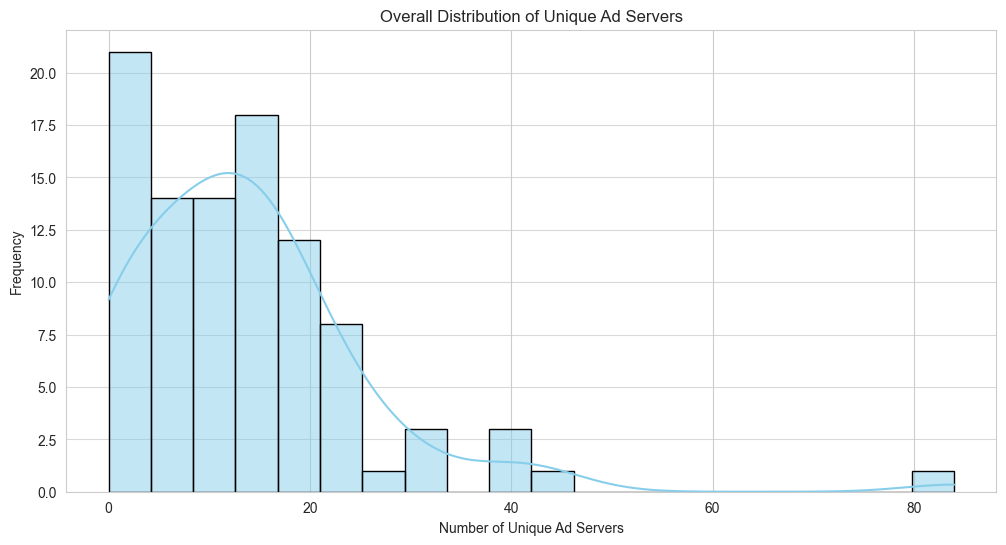

In [62]:
plt.figure(figsize=(12, 6))
sns.histplot(Final_data['UniqueAdServers'], bins=20, color='skyblue', edgecolor='black',kde=True)
plt.title('Overall Distribution of Unique Ad Servers')
plt.xlabel('Number of Unique Ad Servers')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

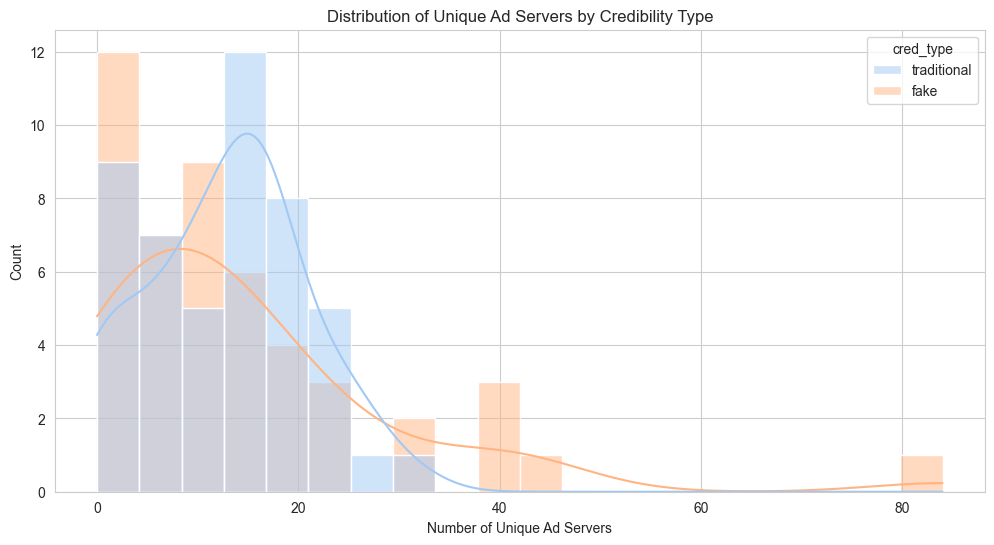

In [60]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(data=Final_data, x='UniqueAdServers', hue='cred_type', bins=20, kde=True, palette='pastel')
plt.title('Distribution of Unique Ad Servers by Credibility Type')
plt.xlabel('Number of Unique Ad Servers')
plt.ylabel('Count')
plt.show()